In [15]:
import cv2
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os
from sklearn.model_selection import train_test_split
import ultralytics
from ultralytics import YOLO
import shutil

In [3]:
images_dir = r'dataset/images'
labels_dir = r'dataset/labels'
aug_images_dir = r'dataset/images_aumented'
aug_labels_dir = r'dataset/labels_aumented'
label_errors_dir = r'dataset/label_errors'

os.makedirs(aug_images_dir, exist_ok=True)
os.makedirs(aug_labels_dir, exist_ok=True)
os.makedirs(label_errors_dir, exist_ok=True)

def load_images_and_labels(images_dir, labels_dir):
    images = []
    labels = []
    for filename in os.listdir(images_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(images_dir, filename)
            label_path = os.path.join(labels_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt'))
            image = cv2.imread(img_path)
            if image is not None:
                images.append(image)
                with open(label_path, 'r') as f:
                    labels.append(f.read())
    return images, labels

def save_augmented_data(image, label, image_name, label_name, aug_images_dir, aug_labels_dir):
    cv2.imwrite(os.path.join(aug_images_dir, image_name), image)
    with open(os.path.join(aug_labels_dir, label_name), 'w') as f:
        f.write(label)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

def validate_bboxes(bboxes):
    for bbox in bboxes:
        if not (0 <= bbox[0] <= 1 and 0 <= bbox[1] <= 1 and 0 <= bbox[2] <= 1 and 0 <= bbox[3] <= 1):
            return False
    return True

def augment_data(image, label):
    boxes = []
    class_labels = []
    for line in label.split('\n'):
        if line.strip() == '':
            continue
        parts = line.strip().split()
        class_labels.append(int(parts[0]))
        boxes.append([float(x) for x in parts[1:]])

    bboxes = []
    for box in boxes:
        bboxes.append(box)

    augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    aug_image = augmented['image']
    aug_bboxes = augmented['bboxes']
    aug_class_labels = augmented['class_labels']

    aug_bboxes = [[max(0, min(1, coord)) for coord in bbox] for bbox in aug_bboxes]

    if not validate_bboxes(aug_bboxes):
        raise ValueError("Bounding box fuera de los límites de la imagen")

    aug_label = ''
    for bbox, cls in zip(aug_bboxes, aug_class_labels):
        aug_label += f"{cls} " + " ".join(map(str, bbox)) + '\n'

    return aug_image, aug_label.strip()

images, labels = load_images_and_labels(images_dir, labels_dir)

for i, (image, label) in enumerate(zip(images, labels)):
    for j in range(5):  
        try:
            aug_image, aug_label = augment_data(image, label)
            image_name = f'aug_{i}_{j}.jpg'
            label_name = f'aug_{i}_{j}.txt'
            save_augmented_data(aug_image, aug_label, image_name, label_name, aug_images_dir, aug_labels_dir)
        except ValueError as e:
            print(f"Error al aumentar la imagen {i} versión {j}: {e}")
            error_image_name = f'error_{i}_{j}.jpg'
            error_label_name = f'error_{i}_{j}.txt'
            cv2.imwrite(os.path.join(label_errors_dir, error_image_name), image)
            with open(os.path.join(label_errors_dir, error_label_name), 'w') as f:
                f.write(label)


Error al aumentar la imagen 14 versión 0: Expected x_min for bbox (-0.07688121890547261, 0.20219216417910446, 0.11450559701492538, 0.6065764925373134, 0.191386815920398, 0.6282649253731343, 0.018812189054726383, 0.6282649253731343, 27) to be in the range [0.0, 1.0], got -0.07688121890547261.
Error al aumentar la imagen 14 versión 1: Expected x_min for bbox (-0.07688121890547261, 0.20219216417910446, 0.11450559701492538, 0.6065764925373134, 0.191386815920398, 0.6282649253731343, 0.018812189054726383, 0.6282649253731343, 27) to be in the range [0.0, 1.0], got -0.07688121890547261.
Error al aumentar la imagen 14 versión 2: Expected x_min for bbox (-0.07688121890547261, 0.20219216417910446, 0.11450559701492538, 0.6065764925373134, 0.191386815920398, 0.6282649253731343, 0.018812189054726383, 0.6282649253731343, 27) to be in the range [0.0, 1.0], got -0.07688121890547261.
Error al aumentar la imagen 14 versión 3: Expected x_min for bbox (-0.07688121890547261, 0.20219216417910446, 0.114505597

In [4]:
label_errors_dir = r'dataset/label_errors'
backup_dir = os.path.join(label_errors_dir, 'backup')

os.makedirs(backup_dir, exist_ok=True)

def is_yolov8_format(label):
    lines = label.strip().split('\n')
    for line in lines:
        parts = line.split()
        if len(parts) != 5:  
            return False
    return True

def convert_to_yolov8(label):
    lines = label.strip().split('\n')
    converted_label = ''
    for line in lines:
        parts = line.split()
        if len(parts) == 9:  
            class_id = parts[0]
            x_center1 = float(parts[1])
            y_center1 = float(parts[2])
            width1 = float(parts[3])
            height1 = float(parts[4])
            x_center2 = float(parts[5])
            y_center2 = float(parts[6])
            width2 = float(parts[7])
            height2 = float(parts[8])
            
            x_center = (x_center1 + x_center2) / 2
            y_center = (y_center1 + y_center2) / 2
            width = (width1 + width2) / 2
            height = (height1 + height2) / 2
            
            converted_label += f"{class_id} {x_center} {y_center} {width} {height}\n"
        else:
            print(f"Warning: Unexpected label format: {line}")
    return converted_label.strip()

for filename in os.listdir(label_errors_dir):
    if filename.endswith('.txt'):
        label_path = os.path.join(label_errors_dir, filename)
        with open(label_path, 'r') as f:
            label = f.read()

        if not is_yolov8_format(label):
            shutil.copy(label_path, os.path.join(backup_dir, filename))

            converted_label = convert_to_yolov8(label)
            with open(label_path, 'w') as f:
                f.write(converted_label)
            print(f"Archivo {filename} convertido a formato YOLOv8 y original respaldado")
        else:
            print(f"Archivo {filename} ya está en formato YOLOv8")


Archivo error_125_0.txt convertido a formato YOLOv8 y original respaldado
Archivo error_125_1.txt convertido a formato YOLOv8 y original respaldado
Archivo error_125_2.txt convertido a formato YOLOv8 y original respaldado
Archivo error_125_3.txt convertido a formato YOLOv8 y original respaldado
Archivo error_125_4.txt convertido a formato YOLOv8 y original respaldado
Archivo error_14_0.txt convertido a formato YOLOv8 y original respaldado
Archivo error_14_1.txt convertido a formato YOLOv8 y original respaldado
Archivo error_14_2.txt convertido a formato YOLOv8 y original respaldado
Archivo error_14_3.txt convertido a formato YOLOv8 y original respaldado
Archivo error_14_4.txt convertido a formato YOLOv8 y original respaldado
Archivo error_153_0.txt convertido a formato YOLOv8 y original respaldado
Archivo error_153_1.txt convertido a formato YOLOv8 y original respaldado
Archivo error_153_2.txt convertido a formato YOLOv8 y original respaldado
Archivo error_153_3.txt convertido a format

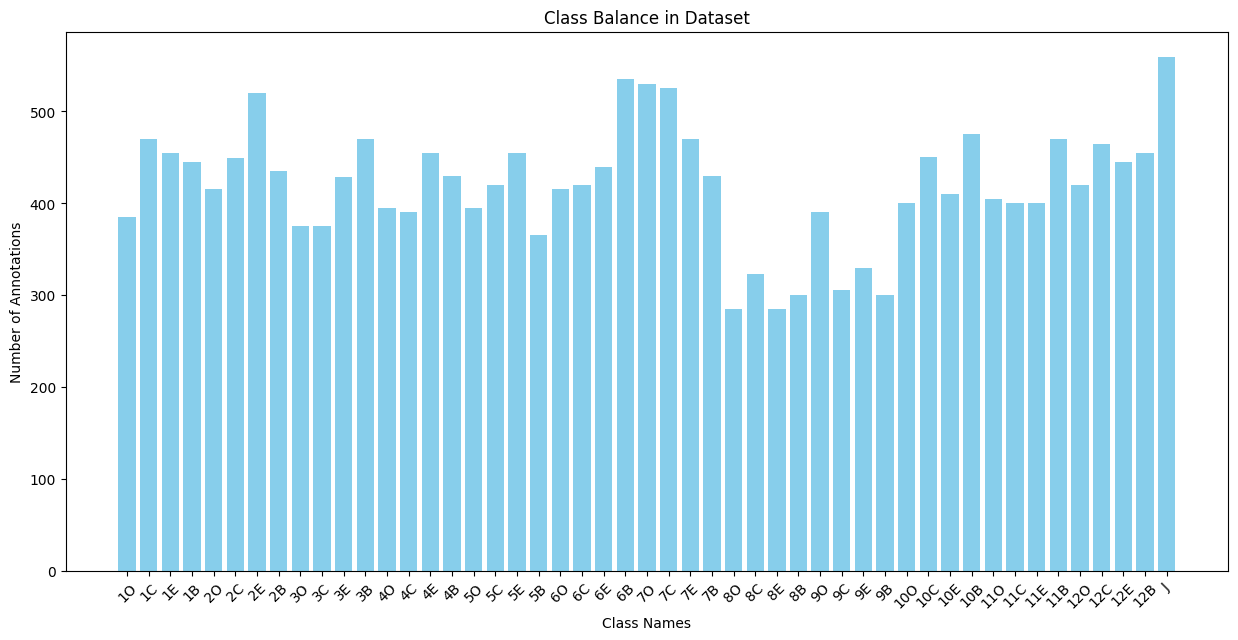

In [7]:

labels_dir = r'dataset/labels_aumented'

# Definir los nombres de las clases
class_names = [
    '1O', '1C', '1E', '1B', '2O', '2C', '2E', '2B', '3O', '3C', '3E', '3B', 
    '4O', '4C', '4E', '4B', '5O', '5C', '5E', '5B', '6O', '6C', '6E', '6B', 
    '7O', '7C', '7E', '7B', '8O', '8C', '8E', '8B', '9O', '9C', '9E', '9B', 
    '10O', '10C', '10E', '10B', '11O', '11C', '11E', '11B', '12O', '12C', '12E', 
    '12B', 'J'
]

name_to_index = {name: str(i) for i, name in enumerate(class_names)}

def count_class_annotations(labels_dir):
    class_counts = defaultdict(int)
    for filename in os.listdir(labels_dir):
        if filename.endswith('.txt'):
            label_path = os.path.join(labels_dir, filename)
            with open(label_path, 'r') as f:
                for line in f:
                    class_id = line.strip().split()[0]
                    class_counts[class_id] += 1
    return class_counts

class_counts = count_class_annotations(labels_dir)

for i in range(50):
    class_counts[str(i)] 

sorted_class_counts = {name: class_counts[name_to_index[name]] for name in class_names}

classes = list(sorted_class_counts.keys())
counts = list(sorted_class_counts.values())

plt.figure(figsize=(15, 7))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class Names')
plt.ylabel('Number of Annotations')
plt.title('Class Balance in Dataset')
plt.xticks(rotation=45)
plt.show()


In [4]:
import fiftyone as fo
import fiftyone.utils.yolo as fouy

images_dir = r'C:\Users\tomas\OneDrive\Desktop\facultad\5to_cuatrimestre\Vision_por_computadora\TruCopilot\dataset\images_aumented'
labels_dir = r'C:\Users\tomas\OneDrive\Desktop\facultad\5to_cuatrimestre\Vision_por_computadora\TruCopilot\dataset\labels_aumented'

# Crear un nuevo dataset en FiftyOne
dataset = fo.Dataset.from_dir(
    dataset_dir=images_dir,
    dataset_type=fo.types.YOLOv5Dataset,
    labels_path=labels_dir
)

# Lanzar la aplicación de FiftyOne para visualizar el dataset
session = fo.launch_app(dataset)



Ignoring unsupported parameter 'labels_path' for importer type <class 'fiftyone.utils.yolo.YOLOv5DatasetImporter'>
 100% |█████████████████| 690/690 [2.4s elapsed, 0s remaining, 273.5 samples/s]      


In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 2.3 MB/s eta 0:00:00:00:0100:01


In [16]:

images_dir = 'dataset\images_aumented'
labels_dir = 'dataset\labels_aumented'
train_images_dir = r'dataset/yolov8/train/images'
train_labels_dir = r'dataset/yolov8/train/labels'
val_images_dir = r'dataset/yolov8/val/images'
val_labels_dir = r'dataset/yolov8/val/labels'

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

images = [f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]
labels = [f.replace('.jpg', '.txt').replace('.png', '.txt') for f in images]

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

def move_files(file_list, source_dir, dest_dir):
    for file_name in file_list:
        shutil.move(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

move_files(train_images, images_dir, train_images_dir)
move_files(val_images, images_dir, val_images_dir)
move_files(train_labels, labels_dir, train_labels_dir)
move_files(val_labels, labels_dir, val_labels_dir)


<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\tomas\AppData\Local\Temp\ipykernel_14576\1715416380.py:1: SyntaxWarning: invalid escape sequence '\i'
  images_dir = 'dataset\images_aumented'
C:\Users\tomas\AppData\Local\Temp\ipykernel_14576\1715416380.py:2: SyntaxWarning: invalid escape sequence '\l'
  labels_dir = 'dataset\labels_aumented'
